# Exploring key predictors of CS enrollment in Washington state

We will be using the data table at https://github.com/lgtanimoto/WAStateCSEd/blob/main/2022/2022_school_pt.csv created from the 2021-22 CSEd Summary Report published by OSPI which shows for each high school, how many students, how many student enrollments, how many male students, how many male student enrollments, how many female students, how many female student enrollments, how many gender X, how many gender X enrollments, and does similar info for race/ethnicity, FRL status, ELL status, disability status.   Cross-sectional data (e.g. how many black female enrollments) is not available. With this data we will generate 300,000 random student records and then perform PCA analysis to discover key predictors of CS enrollment in Washington state.

First, we need to import the libraries we will need to explore and analyze this data.

In [565]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
# import ctgan as ct
# import sdv
#from sdv.single_table import CTGANSynthesizer
#from sdv.datasets.local import load_csvs
#from ctgan import CTGAN
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn import datasets
from sklearn.tree import export_graphviz
from io import StringIO  
from IPython.display import Image  
import pydotplus

Then we will upload the data that we will be using to generate random student records.

In [566]:
ospi_data = pd.read_csv('2022_school_pt.csv',  index_col=0)

Let's take a look at the first few records from the csv file to better understand the school records we are working with.

In [567]:
ospi_data.head()

,DistrictCode,SchoolCode,AllStudents,C_AllStudents,G_Female,GC_Female,G_Male,GC_Male,G_GenderX,GC_GenderX,...,D_NoDisability,DC_NoDisability,A_9,AC_9,A_10,AC_10,A_11,AC_11,A_12,AC_12
0,1109,3075,28,3,9,0,19,3,0,0,...,26,3,7,0,4,0,6,1,11,2
1,1147,3015,1281,169,635,60,646,109,0,0,...,1086,140,382,51,328,44,321,29,250,45
2,1158,2903,60,22,30,12,29,10,1,0,...,57,21,18,12,15,2,14,2,13,6
3,1160,2132,113,24,57,13,56,11,0,0,...,107,20,32,7,35,5,25,4,21,8
4,2250,1617,167,0,89,0,78,0,0,0,...,142,0,16,0,51,0,41,0,59,0


In [568]:
len(ospi_data.index)

730

Next we need to make sure the data is clean and suitable for manipulation by searching for missing values. We will handle normalization later, in different ways, depending on the method for synthetic data generation.

In [569]:
num_missing_val = ospi_data.isnull().sum()
num_missing_val.sum()

0

We see that there are no missing values so now we will move on to generating 300,000 random student records with the help of numpy.

To do this, we need to gather the probabilities implied by the given dataset. These probabilities need to be calculated from each of the columns--comparing the total number of students belonging to each feature category to the number that enrolled in a CS course. We also need to find probabilities for which category a single student will belong to.

In [570]:
ospi_data.columns

Index(['DistrictCode', 'SchoolCode', 'AllStudents', 'C_AllStudents',
       'G_Female', 'GC_Female', 'G_Male', 'GC_Male', 'G_GenderX', 'GC_GenderX',
       'R_Native', 'RC_Native', 'R_Asian', 'RC_Asian', 'R_Black', 'RC_Black',
       'R_Hisp_Lat', 'RC_Hisp_Lat', 'R_HPI', 'RC_HPI', 'R_NA', 'RC_NA',
       'R_TwoOrMore', 'RC_TwoOrMore', 'R_White', 'RC_White', 'L_ELL', 'LC_ELL',
       'L_NoELL', 'LC_NoELL', 'I_LowIncome', 'IC_LowIncome', 'I_NoLowIncome',
       'IC_NOLowIncome', 'D_Disability', 'DC_Disability', 'D_NoDisability',
       'DC_NoDisability', 'A_9', 'AC_9', 'A_10', 'AC_10', 'A_11', 'AC_11',
       'A_12', 'AC_12'],
      dtype='object')

An interesting consideration to begin with is looking at the ratio of all students who enroll in CS:

In [571]:
sum(ospi_data.C_AllStudents) / sum(ospi_data.AllStudents)

0.07654341235652434

This shows that about 7.65% of all students in this dataset enrolled in CS. 

Now, let's go through each of the columns to assign probabilities to every category of student.

In [572]:
Prob_GC_Female = sum(ospi_data.GC_Female) / sum(ospi_data.G_Female)
Prob_GC_Male = sum(ospi_data.GC_Male) / sum(ospi_data.G_Male)
Prob_GC_GenderX = sum(ospi_data.GC_GenderX) / sum(ospi_data.G_GenderX)
Prob_RC_Native = sum(ospi_data.RC_Native) / sum(ospi_data.R_Native)
Prob_RC_Asian = sum(ospi_data.RC_Asian) / sum(ospi_data.R_Asian)
Prob_RC_Black = sum(ospi_data.RC_Black) / sum(ospi_data.R_Black)
Prob_RC_Hisp_Lat = sum(ospi_data.RC_Hisp_Lat) / sum(ospi_data.R_Hisp_Lat)
Prob_RC_HPI = sum(ospi_data.RC_HPI) / sum(ospi_data.R_HPI)
Prob_RC_NA = sum(ospi_data.RC_NA) / sum(ospi_data.R_NA)
Prob_RC_TwoOrMore = sum(ospi_data.RC_TwoOrMore) / sum(ospi_data.R_TwoOrMore)
Prob_RC_White = sum(ospi_data.RC_White) / sum(ospi_data.R_White)
Prob_LC_ELL = sum(ospi_data.LC_ELL) / sum(ospi_data.L_ELL)
Prob_LC_NoELL = sum(ospi_data.LC_NoELL) / sum(ospi_data.L_NoELL)
Prob_IC_LowIncome = sum(ospi_data.IC_LowIncome) / sum(ospi_data.I_LowIncome)
Prob_IC_NoLowIncome = sum(ospi_data.IC_NOLowIncome) / sum(ospi_data.I_NoLowIncome)
Prob_DC_Disability = sum(ospi_data.DC_Disability) / sum(ospi_data.D_Disability)
Prob_DC_NoDisability = sum(ospi_data.DC_NoDisability) / sum(ospi_data.D_NoDisability)
Prob_AC_9 = sum(ospi_data.AC_9) / sum(ospi_data.A_9)
Prob_AC_10 = sum(ospi_data.AC_10) / sum(ospi_data.A_10)
Prob_AC_11 = sum(ospi_data.AC_11) / sum(ospi_data.A_11)
Prob_AC_12 = sum(ospi_data.AC_12) / sum(ospi_data.A_12)

There's more work to do but let's pause and notice that we can now easily compare probabilities, like for gender:

In [573]:
print(Prob_GC_Female)
print(Prob_GC_Male)
print(Prob_GC_GenderX)

0.04510418114369407
0.10592888529774107
0.07277526395173455


These numbers suggest that there's more than double the probability that a male student will enroll in a CS course versus a female student. Also interesting to note is that a student identifying as GenderX has a higher probability of enrolling than a female student. However, this probability may not be completely realistic because there are far fewer students who identify as GenderX, compared to male or female.

In [574]:
print(sum(ospi_data.G_Female))
print(sum(ospi_data.G_Male))
print(sum(ospi_data.G_GenderX))

187078
200493
2652


Next we will find probabilities for which category a student will belong to.

In [575]:
Prob_G_Female = sum(ospi_data.G_Female) / sum(ospi_data.AllStudents)
Prob_G_Male = sum(ospi_data.G_Male) / sum(ospi_data.AllStudents)
Prob_G_GenderX = sum(ospi_data.G_GenderX) / sum(ospi_data.AllStudents)
Prob_R_Native = sum(ospi_data.R_Native) / sum(ospi_data.AllStudents)
Prob_R_Asian = sum(ospi_data.R_Asian) / sum(ospi_data.AllStudents)
Prob_R_Black = sum(ospi_data.R_Black) / sum(ospi_data.AllStudents)
Prob_R_Hisp_Lat = sum(ospi_data.R_Hisp_Lat) / sum(ospi_data.AllStudents)
Prob_R_HPI = sum(ospi_data.R_HPI) / sum(ospi_data.AllStudents)
Prob_R_NA = sum(ospi_data.R_NA) / sum(ospi_data.AllStudents)
Prob_R_TwoOrMore = sum(ospi_data.R_TwoOrMore) / sum(ospi_data.AllStudents)
Prob_R_White = sum(ospi_data.R_White) / sum(ospi_data.AllStudents)
Prob_L_ELL = sum(ospi_data.L_ELL) / sum(ospi_data.AllStudents)
Prob_I_LowIncome = sum(ospi_data.I_LowIncome) / sum(ospi_data.AllStudents)
Prob_I_NoLowIncome = sum(ospi_data.I_NoLowIncome) / sum(ospi_data.AllStudents)
Prob_D_Disability = sum(ospi_data.D_Disability) / sum(ospi_data.AllStudents)
Prob_D_NoDisability = sum(ospi_data.D_NoDisability) / sum(ospi_data.AllStudents)
Prob_A_9 = sum(ospi_data.A_9) / sum(ospi_data.AllStudents)
Prob_A_10 = sum(ospi_data.A_10) / sum(ospi_data.AllStudents)
Prob_A_11 = sum(ospi_data.A_11) / sum(ospi_data.AllStudents)
Prob_A_12 = sum(ospi_data.A_12) / sum(ospi_data.AllStudents)

Now, we can use these probabilities to begin creating a synthetic dataset of student records. Let's start with gender.

In [576]:
rng = np.random.default_rng(seed=6525)

# How many student records we want to generate

num_students = 400000

# Load and normalize probabilities
# Gender

g_probs = np.array([Prob_G_Female, Prob_G_Male, Prob_G_GenderX])
g_probs /= np.sum(g_probs)

# Race

r_probs = np.array([Prob_R_Native, Prob_R_Asian, Prob_R_Black, Prob_R_Hisp_Lat, Prob_R_HPI, Prob_R_NA, Prob_R_TwoOrMore, Prob_R_White])
r_probs /= np.sum(r_probs)

# ELL

e_probs = np.array([1-Prob_L_ELL, Prob_L_ELL])

# Income

i_probs = np.array([Prob_I_NoLowIncome, Prob_I_LowIncome])

# Disability

d_probs = np.array([Prob_D_NoDisability, Prob_D_Disability])

# Grade

a_probs = np.array([Prob_A_9, Prob_A_10, Prob_A_11, Prob_A_12])
a_probs /= np.sum(a_probs)

# Generate values for categorical attributes

rng = np.random.default_rng()
gender = rng.choice(['female', 'male', 'x'], size = num_students, p = g_probs)
race = rng.choice(['Native', 'Asian', 'Black', 'Hisp_Lat', 'HPI', 'NA', 'TwoOrMore', 'White'], size = num_students, p = r_probs)
ell = rng.choice([0, 1], size = num_students, p = e_probs)
income = rng.choice([0, 1], size = num_students, p = i_probs)
disability = rng.choice([0, 1], size = num_students, p = d_probs)
grade = rng.choice(['9', '10', '11', '12'], size = num_students, p = a_probs)

# Print the first few synthetic data points to ensure that this is working as expected
print(gender[:10])
print(race[:10])
print(ell[:10])
print(income[:10])
print(disability[:10])
print(grade[:10])

['female' 'male' 'male' 'female' 'female' 'male' 'female' 'female' 'male'
 'male']
['White' 'White' 'White' 'Hisp_Lat' 'White' 'Hisp_Lat' 'Hisp_Lat' 'White'
 'Hisp_Lat' 'White']
[0 0 0 0 0 0 1 0 0 0]
[1 0 0 1 0 1 0 0 1 1]
[0 0 1 0 0 0 0 1 0 0]
['11' '12' '10' '11' '9' '12' '11' '11' '12' '11']


Let's create a dataframe to hold these new records and add what we've generated as columns.

In [577]:
synth_students = pd.DataFrame()
synth_students.insert(0, "Gender", gender, True)
synth_students.insert(1, "Race", race, True)
synth_students.insert(2, "ELL", ell, True)
synth_students.insert(3, "Low Income", income, True)
synth_students.insert(4, "Disability", disability, True)
synth_students.insert(5, "Grade", grade, True)

After that we can take a look at some of our student records.

In [578]:
synth_students.head()

,Gender,Race,ELL,Low Income,Disability,Grade
0,female,White,0,1,0,11
1,male,White,0,0,0,12
2,male,White,0,0,1,10
3,female,Hisp_Lat,0,1,0,11
4,female,White,0,0,0,9


In [579]:
synth_students.tail()

,Gender,Race,ELL,Low Income,Disability,Grade
399995,female,White,0,0,0,10
399996,female,Hisp_Lat,0,1,1,10
399997,female,TwoOrMore,0,1,0,9
399998,male,Hisp_Lat,0,1,0,11
399999,male,White,0,0,0,9


One thing is missing from this synthetic data--whether or not each synthesized student is enrolled in CS. Creating this column will be a little more complex than the previous because we need to use the probabilities of the column values of each row to calculate whether or not the synthesized student is enrolled in CS.

In order to do this, let's convert all of those synthesized student column values into probabilities that they will be enrolled in CS. E.g. if a column value is "Hisp_Lat" then replace it with the variable Prob_RC_Hisp_Lat that we created earlier.

In [580]:
synth_students.replace("Hisp_Lat", Prob_RC_Hisp_Lat)

,Gender,Race,ELL,Low Income,Disability,Grade
0,female,White,0,1,0,11
1,male,White,0,0,0,12
2,male,White,0,0,1,10
3,female,0.066245,0,1,0,11
4,female,White,0,0,0,9
...,...,...,...,...,...,...
399995,female,White,0,0,0,10
399996,female,0.066245,0,1,1,10
399997,female,TwoOrMore,0,1,0,9
399998,male,0.066245,0,1,0,11


Now, we'll do this for each variable.

In [581]:
synth_students.replace("Hisp_Lat", Prob_RC_Hisp_Lat)

,Gender,Race,ELL,Low Income,Disability,Grade
0,female,White,0,1,0,11
1,male,White,0,0,0,12
2,male,White,0,0,1,10
3,female,0.066245,0,1,0,11
4,female,White,0,0,0,9
...,...,...,...,...,...,...
399995,female,White,0,0,0,10
399996,female,0.066245,0,1,1,10
399997,female,TwoOrMore,0,1,0,9
399998,male,0.066245,0,1,0,11


But it's not best practice to manipulate the dataframe we have. Instead we should create a new dataframe. There are a few ways to do this. Today we will create a new dataframe out of each column, replace(1) values with the associated probabilities, and then bring them back together in a dataframe so that we can calculate our final column of whether or not the student is enrolled in CS.

1: We are using the attribute "inplace=True" to actually manipulate the new dataframes we create out of the columns. In the previous example we did not use this attribute so the dataframe was not actually changed. 

In [582]:
ell_df = synth_students[['ELL']].copy()

In [583]:
ell_df.replace(1, Prob_LC_ELL, inplace=True)
ell_df.head()

,ELL
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [584]:
zero_prob = Prob_LC_NoELL
ell_df.replace(0, zero_prob, inplace=True)
ell_df.head()

,ELL
0,0.078064
1,0.078064
2,0.078064
3,0.078064
4,0.078064


In [585]:
gend_df = synth_students[['Gender']].copy()
race_df = synth_students[['Race']].copy()
inc_df = synth_students[['Low Income']].copy()
dis_df = synth_students[['Disability']].copy()
gr_df = synth_students[['Grade']].copy()

In [586]:
gend_df.replace('male', Prob_GC_Male, inplace=True)
gend_df.replace('female', Prob_GC_Female, inplace=True)
gend_df.replace('x', Prob_GC_GenderX, inplace=True)
gend_df.head()

,Gender
0,0.045104
1,0.105929
2,0.105929
3,0.045104
4,0.045104


In [587]:
race_df.replace('Native', Prob_RC_Native, inplace=True)
race_df.replace('Asian', Prob_RC_Asian, inplace=True)
race_df.replace('Black', Prob_RC_Black, inplace=True)
race_df.replace('Hisp_Lat', Prob_RC_Hisp_Lat, inplace=True)
race_df.replace('HPI', Prob_RC_HPI, inplace=True)
race_df.replace('NA', Prob_RC_NA, inplace=True)
race_df.replace('TwoOrMore', Prob_RC_TwoOrMore, inplace=True)
race_df.replace('White', Prob_RC_White, inplace=True)
race_df.head()

,Race
0,0.072356
1,0.072356
2,0.072356
3,0.066245
4,0.072356


In [588]:
inc_df.replace(0, Prob_IC_NoLowIncome, inplace=True)
inc_df.replace(1, Prob_IC_LowIncome, inplace=True)
inc_df.head()

,Low Income
0,0.067853
1,0.083896
2,0.083896
3,0.067853
4,0.083896


In [589]:
dis_df.replace(0, Prob_DC_NoDisability, inplace=True)
dis_df.replace(1, Prob_DC_Disability, inplace=True)
dis_df.head()

,Disability
0,0.079513
1,0.079513
2,0.056698
3,0.079513
4,0.079513


In [590]:
gr_df.replace('9', Prob_AC_9, inplace=True)
gr_df.replace('10', Prob_AC_10, inplace=True)
gr_df.replace('11', Prob_AC_11, inplace=True)
gr_df.replace('12', Prob_AC_12, inplace=True)
gr_df.head()

,Grade
0,0.061897
1,0.061673
2,0.079958
3,0.061897
4,0.103522


After all of the columns have had their values replaced with probabilities we need to bring them all together in a single dataframe to calculate the probability of enrollment in CS based on those proabibilities. 

In [591]:
calc_prob = pd.DataFrame()
calc_prob["Gender"] = gend_df
calc_prob["Race"] = race_df
calc_prob["ELL"] = ell_df
calc_prob["Income"] = inc_df
calc_prob["Disability"] = dis_df
calc_prob["Grade"] = gr_df
calc_prob.head()

,Gender,Race,ELL,Income,Disability,Grade
0,0.045104,0.072356,0.078064,0.067853,0.079513,0.061897
1,0.105929,0.072356,0.078064,0.083896,0.079513,0.061673
2,0.105929,0.072356,0.078064,0.083896,0.056698,0.079958
3,0.045104,0.066245,0.078064,0.067853,0.079513,0.061897
4,0.045104,0.072356,0.078064,0.083896,0.079513,0.103522


To do this we will need a function to calculate the probability of CS enrollment for each row but are missing important information for conditional probabilities--we know the probability of whether or not somebody enrolls in CS because of one feature, but not multiple features. No cross-sectional or intersectional data is available. So instead we will calculate CS enrollment three ways and decide which is best for our use case. 

In [592]:
def calc_m1_prob(row):
    return min(row['Gender'], row['Race'], row['ELL'], row['Income'], row['Disability'], row['Grade'])


calc_prob['M1_Prob'] = calc_prob.apply(calc_m1_prob, axis=1)


def is_cs_m1(prob):
    return np.random.choice([0, 1], p=[1 - prob, prob])

calc_prob['CS_M1'] = calc_prob['M1_Prob'].apply(is_cs_m1)
calc_prob.head()

,Gender,Race,ELL,Income,Disability,Grade,M1_Prob,CS_M1
0,0.045104,0.072356,0.078064,0.067853,0.079513,0.061897,0.045104,0
1,0.105929,0.072356,0.078064,0.083896,0.079513,0.061673,0.061673,0
2,0.105929,0.072356,0.078064,0.083896,0.056698,0.079958,0.056698,0
3,0.045104,0.066245,0.078064,0.067853,0.079513,0.061897,0.045104,0
4,0.045104,0.072356,0.078064,0.083896,0.079513,0.103522,0.045104,0


Another possible method would be to use the probability found from all students, not taking features into account.

In [593]:
Prob_All = sum(ospi_data.C_AllStudents) / sum(ospi_data.AllStudents)
a_probs = np.array([1-Prob_All, Prob_All])
CS_M2 = rng.choice([0, 1], size = num_students, p = a_probs)
calc_prob.insert(8, "CS_M2", CS_M2, True)
calc_prob.head()

,Gender,Race,ELL,Income,Disability,Grade,M1_Prob,CS_M1,CS_M2
0,0.045104,0.072356,0.078064,0.067853,0.079513,0.061897,0.045104,0,0
1,0.105929,0.072356,0.078064,0.083896,0.079513,0.061673,0.061673,0,0
2,0.105929,0.072356,0.078064,0.083896,0.056698,0.079958,0.056698,0,0
3,0.045104,0.066245,0.078064,0.067853,0.079513,0.061897,0.045104,0,0
4,0.045104,0.072356,0.078064,0.083896,0.079513,0.103522,0.045104,0,0


A third method would be to average the probabilities taken from the synthesized student's features.

In [594]:
def calc_m3_prob(row):
    return (row['Gender'] + row['Race'] + row['ELL'] + row['Income'] + row['Disability'] + row['Grade']) / 6


calc_prob['M3_Prob'] = calc_prob.apply(calc_m3_prob, axis=1)


def is_cs_m3(prob):
    return np.random.choice([0, 1], p=[1 - prob, prob])

calc_prob['CS_M3'] = calc_prob['M3_Prob'].apply(is_cs_m3)
calc_prob.head()

,Gender,Race,ELL,Income,Disability,Grade,M1_Prob,CS_M1,CS_M2,M3_Prob,CS_M3
0,0.045104,0.072356,0.078064,0.067853,0.079513,0.061897,0.045104,0,0,0.067465,0
1,0.105929,0.072356,0.078064,0.083896,0.079513,0.061673,0.061673,0,0,0.080239,0
2,0.105929,0.072356,0.078064,0.083896,0.056698,0.079958,0.056698,0,0,0.079484,0
3,0.045104,0.066245,0.078064,0.067853,0.079513,0.061897,0.045104,0,0,0.066446,0
4,0.045104,0.072356,0.078064,0.083896,0.079513,0.103522,0.045104,0,0,0.077076,1


Let's compare the different percentages of CS enrollment between methods and the sample data.

In [595]:
pct_All_CS_synth1 = f"{sum(calc_prob['CS_M1']) / num_students:%}"
pct_All_CS_synth2 = f"{sum(calc_prob['CS_M2']) / num_students:%}"
pct_All_CS_synth3 = f"{sum(calc_prob['CS_M3']) / num_students:%}"
pct_All_CS_ospi = f"{sum(ospi_data.C_AllStudents) / sum(ospi_data.AllStudents):%}"
print("Method 1:", pct_All_CS_synth1)
print("Method 2:",pct_All_CS_synth2)
print("Method 3:",pct_All_CS_synth3)
print("OSPI Data:",pct_All_CS_ospi)

Method 1: 5.513500%
Method 2: 7.540000%
Method 3: 7.621250%
OSPI Data: 7.654341%


Method 3 appears to yield the closest results.

To better understand how to do this we can explore the data further. Two ways we will look deeper into this data:

- Combine the probability dataframe with the binary data frame so we can look at these together and make sense of them within each synthetic student. Picking the minimum or average may not be the answer, maybe some probabilities should be weighted? Is the random generator ensuring we aren't creating bias in the PCA we want to later perform?
- Divide students by school. This may result in richer analysis, anyway, so we will pursue this option as well for PCA.

In [596]:
all_synth = pd.concat([synth_students, calc_prob], axis=1)
all_synth.head(25)

,Gender,Race,ELL,Low Income,Disability,Grade,Gender,Race,ELL,Income,Disability,Grade,M1_Prob,CS_M1,CS_M2,M3_Prob,CS_M3
0,female,White,0,1,0,11,0.045104,0.072356,0.078064,0.067853,0.079513,0.061897,0.045104,0,0,0.067465,0
1,male,White,0,0,0,12,0.105929,0.072356,0.078064,0.083896,0.079513,0.061673,0.061673,0,0,0.080239,0
2,male,White,0,0,1,10,0.105929,0.072356,0.078064,0.083896,0.056698,0.079958,0.056698,0,0,0.079484,0
3,female,Hisp_Lat,0,1,0,11,0.045104,0.066245,0.078064,0.067853,0.079513,0.061897,0.045104,0,0,0.066446,0
4,female,White,0,0,0,9,0.045104,0.072356,0.078064,0.083896,0.079513,0.103522,0.045104,0,0,0.077076,1
5,male,Hisp_Lat,0,1,0,12,0.105929,0.066245,0.078064,0.067853,0.079513,0.061673,0.061673,0,0,0.076546,0
6,female,Hisp_Lat,1,0,0,11,0.045104,0.066245,0.061587,0.083896,0.079513,0.061897,0.045104,0,0,0.066374,0
7,female,White,0,0,1,11,0.045104,0.072356,0.078064,0.083896,0.056698,0.061897,0.045104,1,0,0.066336,0
8,male,Hisp_Lat,0,1,0,12,0.105929,0.066245,0.078064,0.067853,0.079513,0.061673,0.061673,0,0,0.076546,0
9,male,White,0,1,0,11,0.105929,0.072356,0.078064,0.067853,0.079513,0.061897,0.061897,0,0,0.077602,0


After we've created this last column, we can create our final dataset that will be ready for PCA. One way to prepare this dataset is making all columns binary. This will make analysis simpler (TODO: reword this)

In [597]:
binary_gender = pd.get_dummies(synth_students['Gender'])
binary_gender.head()

,female,male,x
0,1,0,0
1,0,1,0
2,0,1,0
3,1,0,0
4,1,0,0


In [598]:
binary_race = pd.get_dummies(synth_students['Race'])
binary_race.head()

,Asian,Black,HPI,Hisp_Lat,NA,Native,TwoOrMore,White
0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,1
3,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,1


In [599]:
binary_grade = pd.get_dummies(synth_students['Grade'])
binary_grade.head()

,10,11,12,9
0,0,1,0,0
1,0,0,1,0
2,1,0,0,0
3,0,1,0,0
4,0,0,0,1


Then concatenate these new columns with the existing synth_students dataframe and drop the non-binary ones.

In [600]:
binary_synth = pd.concat([synth_students, binary_gender, binary_race, binary_grade, calc_prob['CS_M1'], calc_prob['CS_M2'], calc_prob['CS_M3']], axis=1)
binary_synth = binary_synth.drop('Gender', axis=1)
binary_synth = binary_synth.drop('Race', axis=1)
binary_synth = binary_synth.drop('Grade', axis=1)

binary_synth.head(25)

,ELL,Low Income,Disability,female,male,x,Asian,Black,HPI,Hisp_Lat,...,Native,TwoOrMore,White,10,11,12,9,CS_M1,CS_M2,CS_M3
0,0,1,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
3,0,1,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
5,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
6,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
7,0,0,1,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
8,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
9,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


Next, we will do this process again but maintaining the grouping of students by school. To do this we need to create a function that will do what we've done above for each row in our original dataframe from our sample data.

In [601]:
synth_school = ospi_data.copy()
synth_school = synth_school.drop(['A_9', 'A_10', 'A_11', 'A_12', 'AC_9',
       'AC_10', 'AC_11', 'AC_12', 'G_GenderX', 'GC_GenderX'], axis=1)
synth_probs = pd.DataFrame()
synth_school

,DistrictCode,SchoolCode,AllStudents,C_AllStudents,G_Female,GC_Female,G_Male,GC_Male,R_Native,RC_Native,...,L_NoELL,LC_NoELL,I_LowIncome,IC_LowIncome,I_NoLowIncome,IC_NOLowIncome,D_Disability,DC_Disability,D_NoDisability,DC_NoDisability
0,1109,3075,28,3,9,0,19,3,0,0,...,28,3,17,1,11,2,2,0,26,3
1,1147,3015,1281,169,635,60,646,109,0,0,...,879,115,1069,142,212,27,195,29,1086,140
2,1158,2903,60,22,30,12,29,10,0,0,...,53,19,48,17,12,5,3,1,57,21
3,1160,2132,113,24,57,13,56,11,2,2,...,113,24,47,7,66,17,6,4,107,20
4,2250,1617,167,0,89,0,78,0,1,0,...,167,0,133,0,34,0,25,0,142,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,31006,5703,334,0,151,0,181,0,0,0,...,287,0,127,0,207,0,57,0,277,0
726,36140,5705,25,0,3,0,22,0,0,0,...,25,0,6,0,19,0,1,0,24,0
727,27401,5707,183,4,97,0,86,4,1,0,...,182,4,39,0,144,4,43,0,140,4
728,14172,5708,18,2,8,0,10,2,1,0,...,18,2,16,2,2,0,4,1,14,1


In [602]:
# def calc_m3_prob(row):
#     return (row['Gender'] + row['Race'] + row['ELL'] + row['Income'] + row['Disability'] + row['Grade']) / 6
# Calculating probabilities for each school

# Female

def calc_fem_prob(row):
    return row['G_Female'] / row['AllStudents']

synth_school['G_Female'] = synth_school.apply(calc_fem_prob, axis=1)

# Male

def calc_male_prob(row):
    return row['G_Male'] / row['AllStudents']

synth_school['G_Male'] = synth_school.apply(calc_male_prob, axis=1)

# Native

def calc_native_prob(row):
    return row['R_Native'] / row['AllStudents']

synth_school['R_Native'] = synth_school.apply(calc_native_prob, axis=1)

# Asian

def calc_asian_prob(row):
    return row['R_Asian'] / row['AllStudents']

synth_school['R_Asian'] = synth_school.apply(calc_asian_prob, axis=1)

# Black

def calc_black_prob(row):
    return row['R_Black'] / row['AllStudents']

synth_school['R_Black'] = synth_school.apply(calc_black_prob, axis=1)

# Hisp_Lat

def calc_hisp_lat_prob(row):
    return row['R_Hisp_Lat'] / row['AllStudents']

synth_school['R_Hisp_Lat'] = synth_school.apply(calc_hisp_lat_prob, axis=1)

# HPI

def calc_hpi_prob(row):
    return row['R_HPI'] / row['AllStudents']

synth_school['R_HPI'] = synth_school.apply(calc_hpi_prob, axis=1)

# R_NA

def calc_na_prob(row):
    return row['R_NA'] / row['AllStudents']

synth_school['R_NA'] = synth_school.apply(calc_na_prob, axis=1)

# R_TwoOrMore

def calc_twoormore_prob(row):
    return row['R_TwoOrMore'] / row['AllStudents']

synth_school['R_TwoOrMore'] = synth_school.apply(calc_twoormore_prob, axis=1)

# White

def calc_white_prob(row):
    return row['R_White'] / row['AllStudents']

synth_school['R_White'] = synth_school.apply(calc_white_prob, axis=1)

# ELL

def calc_ell_prob(row):
    return row['L_ELL'] / row['AllStudents']

synth_school['L_ELL'] = synth_school.apply(calc_ell_prob, axis=1)

# No ELL

def calc_noell_prob(row):
    return row['L_NoELL'] / row['AllStudents']

synth_school['L_NoELL'] = synth_school.apply(calc_noell_prob, axis=1)

# Low Income

def calc_lowincome_prob(row):
    return row['I_LowIncome'] / row['AllStudents']

synth_school['I_LowIncome'] = synth_school.apply(calc_lowincome_prob, axis=1)

# No Low Income

def calc_nolow_prob(row):
    return row['I_NoLowIncome'] / row['AllStudents']

synth_school['I_NoLowIncome'] = synth_school.apply(calc_nolow_prob, axis=1)

# Disability

def calc_disability_prob(row):
    return row['D_Disability'] / row['AllStudents']

synth_school['D_Disability'] = synth_school.apply(calc_disability_prob, axis=1)

# No Disability

def calc_nodisability_prob(row):
    return row['D_NoDisability'] / row['AllStudents']

synth_school['D_NoDisability'] = synth_school.apply(calc_nodisability_prob, axis=1)

synth_school.head(25)

,DistrictCode,SchoolCode,AllStudents,C_AllStudents,G_Female,GC_Female,G_Male,GC_Male,R_Native,RC_Native,...,L_NoELL,LC_NoELL,I_LowIncome,IC_LowIncome,I_NoLowIncome,IC_NOLowIncome,D_Disability,DC_Disability,D_NoDisability,DC_NoDisability
0,1109,3075,28,3,0.321429,0,0.678571,3,0.000000,0,...,1.000000,3,0.607143,1,0.392857,2,0.071429,0,0.928571,3
1,1147,3015,1281,169,0.495706,60,0.504294,109,0.000000,0,...,0.686183,115,0.834504,142,0.165496,27,0.152225,29,0.847775,140
2,1158,2903,60,22,0.500000,12,0.483333,10,0.000000,0,...,0.883333,19,0.800000,17,0.200000,5,0.050000,1,0.950000,21
3,1160,2132,113,24,0.504425,13,0.495575,11,0.017699,2,...,1.000000,24,0.415929,7,0.584071,17,0.053097,4,0.946903,20
4,2250,1617,167,0,0.532934,0,0.467066,0,0.005988,0,...,1.000000,0,0.796407,0,0.203593,0,0.149701,0,0.850299,0
5,2250,2299,803,29,0.484433,10,0.514321,19,0.023661,0,...,0.995019,29,0.484433,11,0.515567,18,0.145704,1,0.854296,28
6,2420,2434,177,14,0.497175,3,0.502825,11,0.000000,0,...,1.000000,14,0.350282,9,0.649718,5,0.118644,1,0.881356,13
7,3017,1884,716,0,0.516760,0,0.481844,0,0.005587,0,...,0.921788,0,0.466480,0,0.533520,0,0.087989,0,0.912011,0
8,3017,2826,1911,216,0.492936,49,0.506018,167,0.002093,1,...,0.831502,191,0.653585,136,0.346415,80,0.111983,19,0.888017,197
9,3017,3731,2007,155,0.482810,32,0.515695,123,0.006976,0,...,0.930244,145,0.394619,55,0.605381,100,0.123069,27,0.876931,128


In [603]:
# Calculating probabilities for each school


# Female

def calc_fem_cs_prob(row):
    return row['GC_Female'] / row['C_AllStudents']

synth_school['GC_Female'] = synth_school.apply(calc_fem_cs_prob, axis=1)

# Male

def calc_male_cs_prob(row):
    return row['GC_Male'] / row['C_AllStudents']

synth_school['GC_Male'] = synth_school.apply(calc_male_cs_prob, axis=1)

# Native

def calc_native_cs_prob(row):
    return row['RC_Native'] / row['C_AllStudents']

synth_school['RC_Native'] = synth_school.apply(calc_native_cs_prob, axis=1)

# Asian

def calc_asian_cs_prob(row):
    return row['RC_Asian'] / row['C_AllStudents']

synth_school['RC_Asian'] = synth_school.apply(calc_asian_cs_prob, axis=1)

# Black

def calc_black_cs_prob(row):
    return row['RC_Black'] / row['C_AllStudents']

synth_school['RC_Black'] = synth_school.apply(calc_black_cs_prob, axis=1)

# Hisp_Lat

def calc_hisp_lat_cs_prob(row):
    return row['RC_Hisp_Lat'] / row['C_AllStudents']

synth_school['RC_Hisp_Lat'] = synth_school.apply(calc_hisp_lat_cs_prob, axis=1)

# HPI

def calc_hpi_cs_prob(row):
    return row['RC_HPI'] / row['C_AllStudents']

synth_school['RC_HPI'] = synth_school.apply(calc_hpi_cs_prob, axis=1)

# RC_NA

def calc_na_cs_prob(row):
    return row['RC_NA'] / row['C_AllStudents']

synth_school['RC_NA'] = synth_school.apply(calc_na_cs_prob, axis=1)

# RC_TwoOrMore

def calc_twoormore_cs_prob(row):
    return row['RC_TwoOrMore'] / row['C_AllStudents']

synth_school['RC_TwoOrMore'] = synth_school.apply(calc_twoormore_cs_prob, axis=1)

# White

def calc_white_cs_prob(row):
    return row['RC_White'] / row['C_AllStudents']

synth_school['RC_White'] = synth_school.apply(calc_white_cs_prob, axis=1)

# ELL

def calc_ell_cs_prob(row):
    return row['LC_ELL'] / row['C_AllStudents']

synth_school['LC_ELL'] = synth_school.apply(calc_ell_cs_prob, axis=1)

# No ELL

def calc_noell_cs_prob(row):
    return row['LC_NoELL'] / row['C_AllStudents']

synth_school['LC_NoELL'] = synth_school.apply(calc_noell_cs_prob, axis=1)

# Low Income

def calc_lowincome_cs_prob(row):
    return row['IC_LowIncome'] / row['C_AllStudents']

synth_school['IC_LowIncome'] = synth_school.apply(calc_lowincome_cs_prob, axis=1)

# No Low Income

def calc_nolow_cs_prob(row):
    return row['IC_NOLowIncome'] / row['C_AllStudents']

synth_school['IC_NOLowIncome'] = synth_school.apply(calc_nolow_cs_prob, axis=1)

# Disability

def calc_disability_cs_prob(row):
    return row['DC_Disability'] / row['C_AllStudents']

synth_school['DC_Disability'] = synth_school.apply(calc_disability_cs_prob, axis=1)

# No Disability

def calc_nodisability_cs_prob(row):
    return row['DC_NoDisability'] / row['C_AllStudents']

synth_school['DC_NoDisability'] = synth_school.apply(calc_nodisability_cs_prob, axis=1)

synth_school.head(25)

,DistrictCode,SchoolCode,AllStudents,C_AllStudents,G_Female,GC_Female,G_Male,GC_Male,R_Native,RC_Native,...,L_NoELL,LC_NoELL,I_LowIncome,IC_LowIncome,I_NoLowIncome,IC_NOLowIncome,D_Disability,DC_Disability,D_NoDisability,DC_NoDisability
0,1109,3075,28,3,0.321429,0.000000,0.678571,1.000000,0.000000,0.000000,...,1.000000,1.000000,0.607143,0.333333,0.392857,0.666667,0.071429,0.000000,0.928571,1.000000
1,1147,3015,1281,169,0.495706,0.355030,0.504294,0.644970,0.000000,0.000000,...,0.686183,0.680473,0.834504,0.840237,0.165496,0.159763,0.152225,0.171598,0.847775,0.828402
2,1158,2903,60,22,0.500000,0.545455,0.483333,0.454545,0.000000,0.000000,...,0.883333,0.863636,0.800000,0.772727,0.200000,0.227273,0.050000,0.045455,0.950000,0.954545
3,1160,2132,113,24,0.504425,0.541667,0.495575,0.458333,0.017699,0.083333,...,1.000000,1.000000,0.415929,0.291667,0.584071,0.708333,0.053097,0.166667,0.946903,0.833333
4,2250,1617,167,0,0.532934,NaN,0.467066,NaN,0.005988,NaN,...,1.000000,NaN,0.796407,NaN,0.203593,NaN,0.149701,NaN,0.850299,NaN
5,2250,2299,803,29,0.484433,0.344828,0.514321,0.655172,0.023661,0.000000,...,0.995019,1.000000,0.484433,0.379310,0.515567,0.620690,0.145704,0.034483,0.854296,0.965517
6,2420,2434,177,14,0.497175,0.214286,0.502825,0.785714,0.000000,0.000000,...,1.000000,1.000000,0.350282,0.642857,0.649718,0.357143,0.118644,0.071429,0.881356,0.928571
7,3017,1884,716,0,0.516760,NaN,0.481844,NaN,0.005587,NaN,...,0.921788,NaN,0.466480,NaN,0.533520,NaN,0.087989,NaN,0.912011,NaN
8,3017,2826,1911,216,0.492936,0.226852,0.506018,0.773148,0.002093,0.004630,...,0.831502,0.884259,0.653585,0.629630,0.346415,0.370370,0.111983,0.087963,0.888017,0.912037
9,3017,3731,2007,155,0.482810,0.206452,0.515695,0.793548,0.006976,0.000000,...,0.930244,0.935484,0.394619,0.354839,0.605381,0.645161,0.123069,0.174194,0.876931,0.825806


An observation of interest has become more visible now--some schools don't have any students enrolled in CS, most likely because it is not available. Let's see how many schools do not have any CS student enrollments.

In [604]:
ospi_data[ospi_data['C_AllStudents'] == 0].count()

DistrictCode       365
SchoolCode         365
AllStudents        365
C_AllStudents      365
G_Female           365
GC_Female          365
G_Male             365
GC_Male            365
G_GenderX          365
GC_GenderX         365
R_Native           365
RC_Native          365
R_Asian            365
RC_Asian           365
R_Black            365
RC_Black           365
R_Hisp_Lat         365
RC_Hisp_Lat        365
R_HPI              365
RC_HPI             365
R_NA               365
RC_NA              365
R_TwoOrMore        365
RC_TwoOrMore       365
R_White            365
RC_White           365
L_ELL              365
LC_ELL             365
L_NoELL            365
LC_NoELL           365
I_LowIncome        365
IC_LowIncome       365
I_NoLowIncome      365
IC_NOLowIncome     365
D_Disability       365
DC_Disability      365
D_NoDisability     365
DC_NoDisability    365
A_9                365
AC_9               365
A_10               365
AC_10              365
A_11               365
AC_11      

That's out of 730 school records. So half of these schools do not appear to offer CS. For now, let's concentrate on the schools that do have CS enrollments.

In [605]:
cs_schools = synth_school[synth_school['C_AllStudents'] != 0]
cs_schools.head(25)

,DistrictCode,SchoolCode,AllStudents,C_AllStudents,G_Female,GC_Female,G_Male,GC_Male,R_Native,RC_Native,...,L_NoELL,LC_NoELL,I_LowIncome,IC_LowIncome,I_NoLowIncome,IC_NOLowIncome,D_Disability,DC_Disability,D_NoDisability,DC_NoDisability
0,1109,3075,28,3,0.321429,0.000000,0.678571,1.000000,0.000000,0.000000,...,1.000000,1.000000,0.607143,0.333333,0.392857,0.666667,0.071429,0.000000,0.928571,1.000000
1,1147,3015,1281,169,0.495706,0.355030,0.504294,0.644970,0.000000,0.000000,...,0.686183,0.680473,0.834504,0.840237,0.165496,0.159763,0.152225,0.171598,0.847775,0.828402
2,1158,2903,60,22,0.500000,0.545455,0.483333,0.454545,0.000000,0.000000,...,0.883333,0.863636,0.800000,0.772727,0.200000,0.227273,0.050000,0.045455,0.950000,0.954545
3,1160,2132,113,24,0.504425,0.541667,0.495575,0.458333,0.017699,0.083333,...,1.000000,1.000000,0.415929,0.291667,0.584071,0.708333,0.053097,0.166667,0.946903,0.833333
5,2250,2299,803,29,0.484433,0.344828,0.514321,0.655172,0.023661,0.000000,...,0.995019,1.000000,0.484433,0.379310,0.515567,0.620690,0.145704,0.034483,0.854296,0.965517
6,2420,2434,177,14,0.497175,0.214286,0.502825,0.785714,0.000000,0.000000,...,1.000000,1.000000,0.350282,0.642857,0.649718,0.357143,0.118644,0.071429,0.881356,0.928571
8,3017,2826,1911,216,0.492936,0.226852,0.506018,0.773148,0.002093,0.004630,...,0.831502,0.884259,0.653585,0.629630,0.346415,0.370370,0.111983,0.087963,0.888017,0.912037
9,3017,3731,2007,155,0.482810,0.206452,0.515695,0.793548,0.006976,0.000000,...,0.930244,0.935484,0.394619,0.354839,0.605381,0.645161,0.123069,0.174194,0.876931,0.825806
11,3017,4118,392,17,0.530612,0.117647,0.469388,0.882353,0.002551,0.058824,...,1.000000,1.000000,0.369898,0.235294,0.630102,0.764706,0.002551,0.000000,0.997449,1.000000
12,3017,4484,1894,92,0.478881,0.173913,0.516895,0.815217,0.005280,0.000000,...,0.896515,0.945652,0.513200,0.500000,0.486800,0.500000,0.099261,0.043478,0.900739,0.956522


In [606]:
def calc_all_cs_cs_prob(row):
    return row['C_AllStudents'] / row['AllStudents']

cs_schools['C_AllStudents'] = cs_schools.apply(calc_all_cs_cs_prob, axis=1)
cs_schools.head(20)

,DistrictCode,SchoolCode,AllStudents,C_AllStudents,G_Female,GC_Female,G_Male,GC_Male,R_Native,RC_Native,...,L_NoELL,LC_NoELL,I_LowIncome,IC_LowIncome,I_NoLowIncome,IC_NOLowIncome,D_Disability,DC_Disability,D_NoDisability,DC_NoDisability
0,1109,3075,28,0.107143,0.321429,0.000000,0.678571,1.000000,0.000000,0.000000,...,1.000000,1.000000,0.607143,0.333333,0.392857,0.666667,0.071429,0.000000,0.928571,1.000000
1,1147,3015,1281,0.131928,0.495706,0.355030,0.504294,0.644970,0.000000,0.000000,...,0.686183,0.680473,0.834504,0.840237,0.165496,0.159763,0.152225,0.171598,0.847775,0.828402
2,1158,2903,60,0.366667,0.500000,0.545455,0.483333,0.454545,0.000000,0.000000,...,0.883333,0.863636,0.800000,0.772727,0.200000,0.227273,0.050000,0.045455,0.950000,0.954545
3,1160,2132,113,0.212389,0.504425,0.541667,0.495575,0.458333,0.017699,0.083333,...,1.000000,1.000000,0.415929,0.291667,0.584071,0.708333,0.053097,0.166667,0.946903,0.833333
5,2250,2299,803,0.036115,0.484433,0.344828,0.514321,0.655172,0.023661,0.000000,...,0.995019,1.000000,0.484433,0.379310,0.515567,0.620690,0.145704,0.034483,0.854296,0.965517
6,2420,2434,177,0.079096,0.497175,0.214286,0.502825,0.785714,0.000000,0.000000,...,1.000000,1.000000,0.350282,0.642857,0.649718,0.357143,0.118644,0.071429,0.881356,0.928571
8,3017,2826,1911,0.113030,0.492936,0.226852,0.506018,0.773148,0.002093,0.004630,...,0.831502,0.884259,0.653585,0.629630,0.346415,0.370370,0.111983,0.087963,0.888017,0.912037
9,3017,3731,2007,0.077230,0.482810,0.206452,0.515695,0.793548,0.006976,0.000000,...,0.930244,0.935484,0.394619,0.354839,0.605381,0.645161,0.123069,0.174194,0.876931,0.825806
11,3017,4118,392,0.043367,0.530612,0.117647,0.469388,0.882353,0.002551,0.058824,...,1.000000,1.000000,0.369898,0.235294,0.630102,0.764706,0.002551,0.000000,0.997449,1.000000
12,3017,4484,1894,0.048574,0.478881,0.173913,0.516895,0.815217,0.005280,0.000000,...,0.896515,0.945652,0.513200,0.500000,0.486800,0.500000,0.099261,0.043478,0.900739,0.956522


It may be of interest to pause and observe how much richer this already makes the analysis--you can see how the probabilities vary by school. For instance, notice how much the GC_Female column varies between schools.

In [607]:
cs_schools = cs_schools.loc[cs_schools.index.repeat(cs_schools.AllStudents)]


cs_schools.head(40)

,DistrictCode,SchoolCode,AllStudents,C_AllStudents,G_Female,GC_Female,G_Male,GC_Male,R_Native,RC_Native,...,L_NoELL,LC_NoELL,I_LowIncome,IC_LowIncome,I_NoLowIncome,IC_NOLowIncome,D_Disability,DC_Disability,D_NoDisability,DC_NoDisability
0,1109,3075,28,0.107143,0.321429,0.00000,0.678571,1.00000,0.0,0.0,...,1.000000,1.000000,0.607143,0.333333,0.392857,0.666667,0.071429,0.000000,0.928571,1.000000
0,1109,3075,28,0.107143,0.321429,0.00000,0.678571,1.00000,0.0,0.0,...,1.000000,1.000000,0.607143,0.333333,0.392857,0.666667,0.071429,0.000000,0.928571,1.000000
0,1109,3075,28,0.107143,0.321429,0.00000,0.678571,1.00000,0.0,0.0,...,1.000000,1.000000,0.607143,0.333333,0.392857,0.666667,0.071429,0.000000,0.928571,1.000000
0,1109,3075,28,0.107143,0.321429,0.00000,0.678571,1.00000,0.0,0.0,...,1.000000,1.000000,0.607143,0.333333,0.392857,0.666667,0.071429,0.000000,0.928571,1.000000
0,1109,3075,28,0.107143,0.321429,0.00000,0.678571,1.00000,0.0,0.0,...,1.000000,1.000000,0.607143,0.333333,0.392857,0.666667,0.071429,0.000000,0.928571,1.000000
0,1109,3075,28,0.107143,0.321429,0.00000,0.678571,1.00000,0.0,0.0,...,1.000000,1.000000,0.607143,0.333333,0.392857,0.666667,0.071429,0.000000,0.928571,1.000000
0,1109,3075,28,0.107143,0.321429,0.00000,0.678571,1.00000,0.0,0.0,...,1.000000,1.000000,0.607143,0.333333,0.392857,0.666667,0.071429,0.000000,0.928571,1.000000
0,1109,3075,28,0.107143,0.321429,0.00000,0.678571,1.00000,0.0,0.0,...,1.000000,1.000000,0.607143,0.333333,0.392857,0.666667,0.071429,0.000000,0.928571,1.000000
0,1109,3075,28,0.107143,0.321429,0.00000,0.678571,1.00000,0.0,0.0,...,1.000000,1.000000,0.607143,0.333333,0.392857,0.666667,0.071429,0.000000,0.928571,1.000000
0,1109,3075,28,0.107143,0.321429,0.00000,0.678571,1.00000,0.0,0.0,...,1.000000,1.000000,0.607143,0.333333,0.392857,0.666667,0.071429,0.000000,0.928571,1.000000


In [618]:
rng2 = np.random.default_rng(seed=6525)


def student_gender(row):

    g_probs = np.array([row['G_Female'], row['G_Male']])
    
    g_probs /= np.sum(g_probs)
    
    return rng2.choice(['female', 'male'], size = 1, p = g_probs)
    
cs_schools['gender'] = cs_schools.apply(student_gender, axis=1)

In [620]:
def student_race(row):
    
    r_probs = np.array([row['R_Native'], row['R_Asian'], row['R_Black'], row['R_Hisp_Lat'], row['R_HPI'], 
                       row['R_NA'], row['R_TwoOrMore'], row['R_White']])
    r_probs /= np.sum(r_probs)
    
    return rng2.choice(['Native', 'Asian', 'Black', 'Hisp_Lat', 'HPI', 'NA', 'TwoOrMore', 'White'], size = 1, p = r_probs)

cs_schools['race'] = cs_schools.apply(student_race, axis=1)

In [623]:
def student_ell(row):
    e_probs = np.array([row['L_ELL'], row['L_NoELL']])
    
    e_probs /= np.sum(e_probs)
    
    return rng2.choice([1, 0], size = 1, p = e_probs)

cs_schools['ell'] = cs_schools.apply(student_ell, axis=1)

In [626]:
def student_low_income(row):
    i_probs = np.array([row['I_LowIncome'], row['I_NoLowIncome']])
    
    i_probs /= np.sum(i_probs)
    
    return rng2.choice([1, 0], size = 1, p = i_probs)

cs_schools['low_income'] = cs_schools.apply(student_low_income, axis=1)

In [628]:
def student_disability(row):
    d_probs = np.array([row['D_Disability'], row['D_NoDisability']])
    
    d_probs /= np.sum(d_probs)
    
    return rng2.choice([1, 0], size = 1, p = d_probs)

cs_schools['disability'] = cs_schools.apply(student_disability, axis=1)

In [629]:
cs_schools.head(50)

,DistrictCode,SchoolCode,AllStudents,C_AllStudents,G_Female,GC_Female,G_Male,GC_Male,R_Native,RC_Native,...,IC_NOLowIncome,D_Disability,DC_Disability,D_NoDisability,DC_NoDisability,gender,race,ell,low_income,disability
0,1109,3075,28,0.107143,0.321429,0.00000,0.678571,1.00000,0.0,0.0,...,0.666667,0.071429,0.000000,0.928571,1.000000,[male],[White],[0],[0],[0]
0,1109,3075,28,0.107143,0.321429,0.00000,0.678571,1.00000,0.0,0.0,...,0.666667,0.071429,0.000000,0.928571,1.000000,[male],[Hisp_Lat],[0],[1],[0]
0,1109,3075,28,0.107143,0.321429,0.00000,0.678571,1.00000,0.0,0.0,...,0.666667,0.071429,0.000000,0.928571,1.000000,[female],[White],[0],[0],[1]
0,1109,3075,28,0.107143,0.321429,0.00000,0.678571,1.00000,0.0,0.0,...,0.666667,0.071429,0.000000,0.928571,1.000000,[male],[White],[0],[0],[0]
0,1109,3075,28,0.107143,0.321429,0.00000,0.678571,1.00000,0.0,0.0,...,0.666667,0.071429,0.000000,0.928571,1.000000,[female],[White],[0],[0],[0]
0,1109,3075,28,0.107143,0.321429,0.00000,0.678571,1.00000,0.0,0.0,...,0.666667,0.071429,0.000000,0.928571,1.000000,[male],[White],[0],[1],[1]
0,1109,3075,28,0.107143,0.321429,0.00000,0.678571,1.00000,0.0,0.0,...,0.666667,0.071429,0.000000,0.928571,1.000000,[male],[White],[0],[1],[0]
0,1109,3075,28,0.107143,0.321429,0.00000,0.678571,1.00000,0.0,0.0,...,0.666667,0.071429,0.000000,0.928571,1.000000,[female],[White],[0],[1],[0]
0,1109,3075,28,0.107143,0.321429,0.00000,0.678571,1.00000,0.0,0.0,...,0.666667,0.071429,0.000000,0.928571,1.000000,[female],[White],[0],[1],[0]
0,1109,3075,28,0.107143,0.321429,0.00000,0.678571,1.00000,0.0,0.0,...,0.666667,0.071429,0.000000,0.928571,1.000000,[male],[White],[0],[1],[0]


TODO:

School size:  small (300 <= ) – 0
                           Medium (300 < x <= 1200) – 0.5
                           Large ( 1200 < ) – 0
 
School income ( <20% LowIncome) – 0
                                 (20 – 40 LI) – 0.25
                                 (40 – 60 LI) – 0.5
                                  (60 -80 LI)  - 0.75                                   (> 80 LI) – 1.0

In [533]:




# features = ['G_Female', 'G_Male',
#        'R_Native', 'R_Asian',
#        'R_Black', 'R_Hisp_Lat', 'R_HPI',
#        'R_NA', 'R_TwoOrMore', 'R_White',
#        'L_ELL', 'L_NoELL', 'I_LowIncome',
#        'I_NoLowIncome', 'D_Disability',
#        'D_NoDisability']

# cs_features = ['GC_Female', 'GC_Male',
#        'RC_Native','RC_Asian',
#        'RC_Black', 'RC_Hisp_Lat', 'RC_HPI',
#        'RC_NA', 'RC_TwoOrMore', 'RC_White',
#        'LC_ELL', 'LC_NoELL', 'IC_LowIncome', 
#        'IC_NOLowIncome', 'DC_Disability',
#        'DC_NoDisability']

# for feature in features:
#     synth_probs[feature] = synth_school.apply(lambda row: row[feature] / row['AllStudents'], axis=1)

    
# for cs_feature, feature in zip(cs_features, features):
#     synth_probs[cs_feature] = synth_school.apply(lambda row, c=cs_feature, f=feature: row[c] / row[f] if row[f] != 0 else np.nan, axis=1)
    
# synth_probs.head(25)
    
# synth_sch_stu.head(50)

In [534]:
# synth_sch_stu = synth_sch_stu.drop('AllStudents', axis=1)
# synth_sch_stu_a = synth_sch_stu.drop(['GC_Female', 'GC_Male',
#        'GC_GenderX', 'RC_Native','RC_Asian',
#        'RC_Black', 'RC_Hisp_Lat', 'RC_HPI',
#        'RC_NA', 'RC_TwoOrMore', 'RC_White',
#        'LC_ELL', 'LC_NoELL', 'IC_LowIncome', 
#        'IC_NOLowIncome', 'DC_Disability',
#        'DC_NoDisability', 'AC_9',
#        'AC_10', 'AC_11', 'AC_12'], axis=1)
# synth_sch_stu_a.head()

In [535]:
# def is_feature(prob):
#     if np.isnan(prob):
#         return np.nan
#     else:
#         return np.random.choice([0, 1], p=[1 - prob, prob])
    
# binary_synth_sch_a = synth_sch_stu_a.applymap(is_feature)

# binary_synth_sch_a.head(50)

## Decision Tree

We need to denote the independent and dependent variables. We can use the column names and remove the CS enrollment columns for our features list.

In [536]:
binary_synth = binary_synth.drop(['CS_M1', 'CS_M2'], axis=1) # We will only be using Method 3 going forward
student_features = list(binary_synth.columns)
print(student_features)

['ELL', 'Low Income', 'Disability', 'female', 'male', 'x', 'Asian', 'Black', 'HPI', 'Hisp_Lat', 'NA', 'Native', 'TwoOrMore', 'White', '10', '11', '12', '9', 'CS_M3']


In [537]:
student_features.remove('CS_M3')
print(student_features)

['ELL', 'Low Income', 'Disability', 'female', 'male', 'x', 'Asian', 'Black', 'HPI', 'Hisp_Lat', 'NA', 'Native', 'TwoOrMore', 'White', '10', '11', '12', '9']


And, of course, we have CS enrollment as the dependent variable. We will assign these to x and y variables. In this first round we will concentrate on our first generated dataset and use CS_M3 as our dependent variable.

In [538]:
x = binary_synth[student_features]
y = binary_synth.CS_M3

In [539]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

In [540]:
clf = DecisionTreeClassifier(max_depth = 4)

clf = clf.fit(x_train,y_train)

y_pred = clf.predict(x_test)

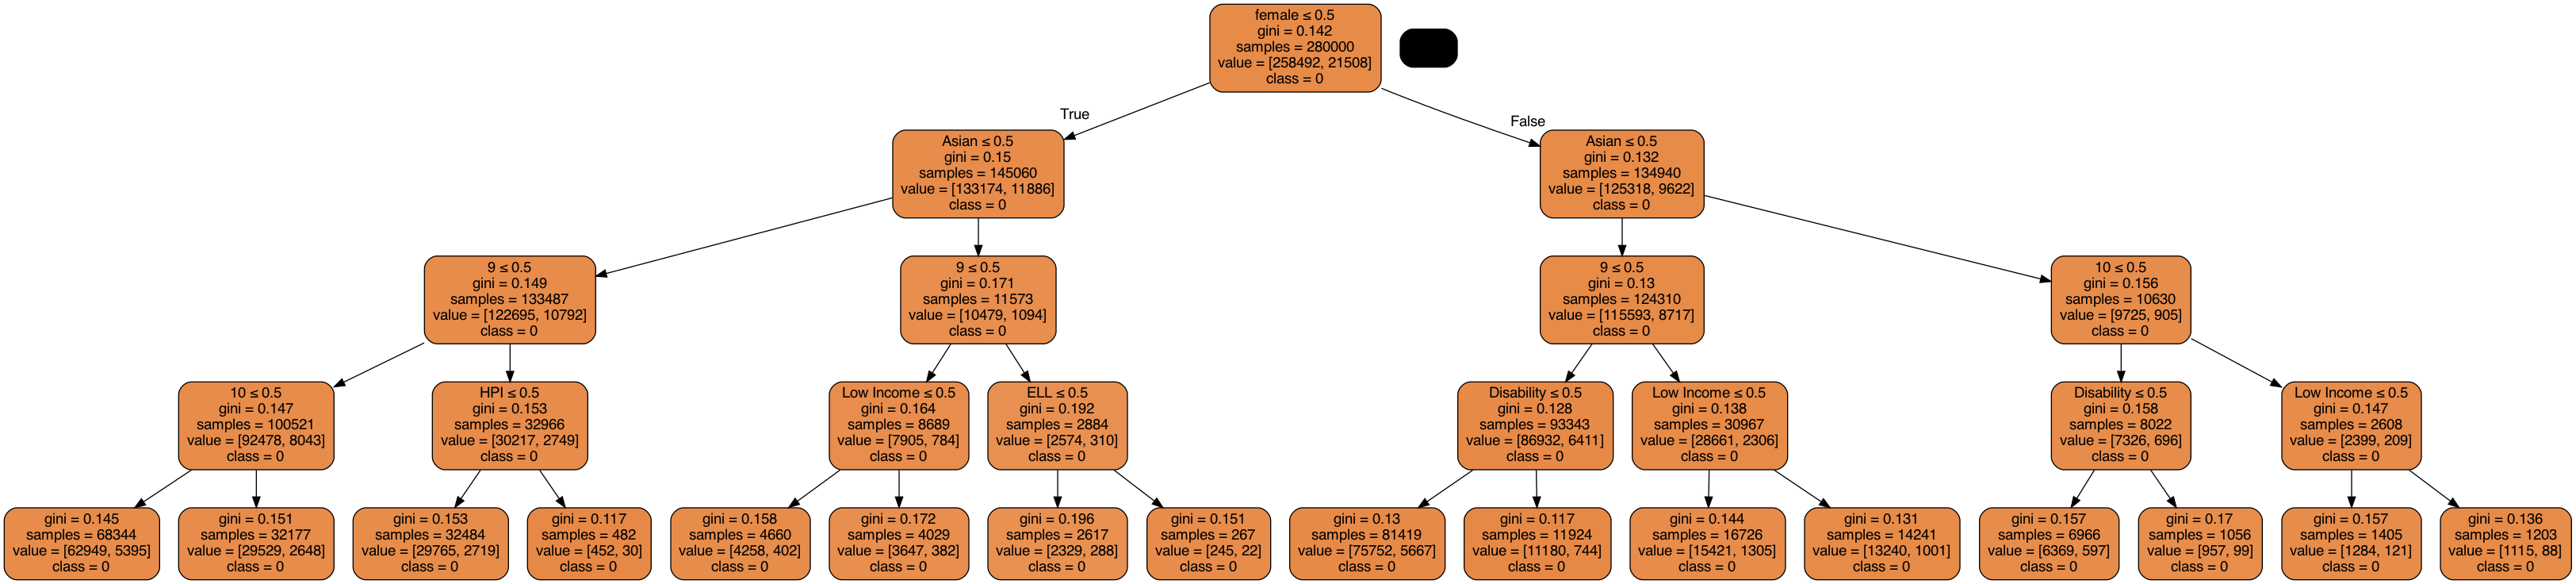

In [541]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = student_features,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('WA_CS_Students_M3.png')
Image(graph.create_png())

There are two issues with the above image: it is difficult to pick out key indicators and there is a possibility of overfitting. However, if the max_depth or min_samples_split are any less then there are zero students classified as "1" for CS enrollment. We will try a tree with less depth but know that there will only be students classified as "0" in our results. Is there still a way to make this meaningful? Maybe we instead have indicators for not enrolling in CS?

In [542]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.923825


This appears to be a good score, but a confusion matrix will reveal a lot more information about the success of the decision tree classifier.

Confusion matrix

 [[110859      0]
 [  9141      0]]


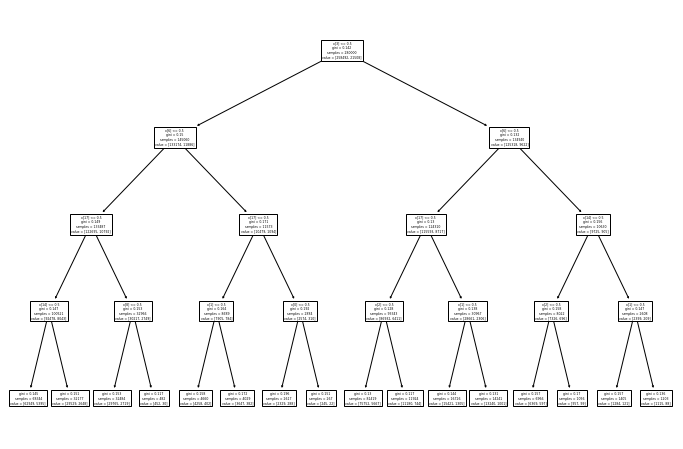

In [543]:

plt.figure(figsize=(12,8))
from sklearn import tree
tree.plot_tree(clf.fit(x_train, y_train))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)

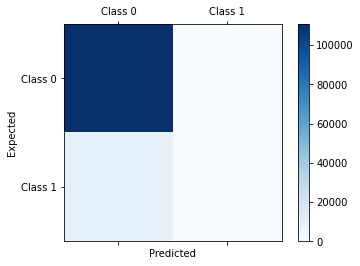

In [544]:
import warnings
warnings.filterwarnings('ignore')

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

Here we can see that the accuracy is actually not great. There are not any false positives and plenty of true positives, but there are quite a few false negatives and zero true negatives. To further help describe what this means in this context:

* true positive: algorithm predicted Class 0 and we expected Class 0
* true negative: algorithm predicted Class 1 and we expected Class 1
* false positive: algorithm predicted Class 1 and we expected Class 0
* false negative: algorithm predicted Class 0 and we expected Class 1

### Imbalanced Classes

Furthermore, it appears that the issue here is that the dataset's classes are imbalanced. If you consider the accuracy score of ~92% and recall that a 7.65% of students were enrolled in CS this imbalance begins to make sense. This has fallen to the [Accuracy Paradox](https://towardsdatascience.com/accuracy-paradox-897a69e2dd9b). What happens is that the algorithm, understandably, decides to just predict one class and voila--high accuracy is acheived because one class is present over 90% of the time! 

To work around this issue we will balance the classes using undersampling methods (undersampling is recommended when a dataset has hundreds of thousands of records versus oversampling which is better for problems with less data). We will undersample with the more simple sample package and then with the imbalanced-learn module.  Then we will test a few different class ratios.

### Undersampling

First, let's look at the current ratio of our dataset's classes.

Class 0: 369351
Class 1: 30649
Proportion: 12.05 : 1


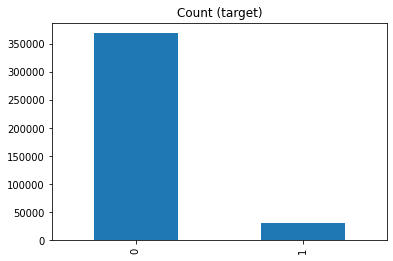

In [545]:
undersample_bisynth = binary_synth.copy(deep=False)


target_count = undersample_bisynth.CS_M3.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

In [546]:
undersample_bisynth.head()

,ELL,Low Income,Disability,female,male,x,Asian,Black,HPI,Hisp_Lat,NA,Native,TwoOrMore,White,10,11,12,9,CS_M3
0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1
2,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0
4,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


Undersampling using the pandas library's sample().

Random under-sampling:
0    30649
1    30649
Name: CS_M3, dtype: int64


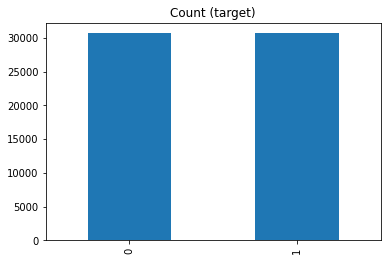

In [547]:
count_class_0, count_class_1 = undersample_bisynth.CS_M3.value_counts()

df_class_0 = undersample_bisynth[undersample_bisynth['CS_M3'] == 0]
df_class_1 = undersample_bisynth[undersample_bisynth['CS_M3'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.CS_M3.value_counts())

df_test_under.CS_M3.value_counts().plot(kind='bar', title='Count (target)');

In [548]:
df_test_under.head()

,ELL,Low Income,Disability,female,male,x,Asian,Black,HPI,Hisp_Lat,NA,Native,TwoOrMore,White,10,11,12,9,CS_M3
274269,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
142616,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
264085,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
191847,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
296447,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0


Now, let's try the decision tree again.

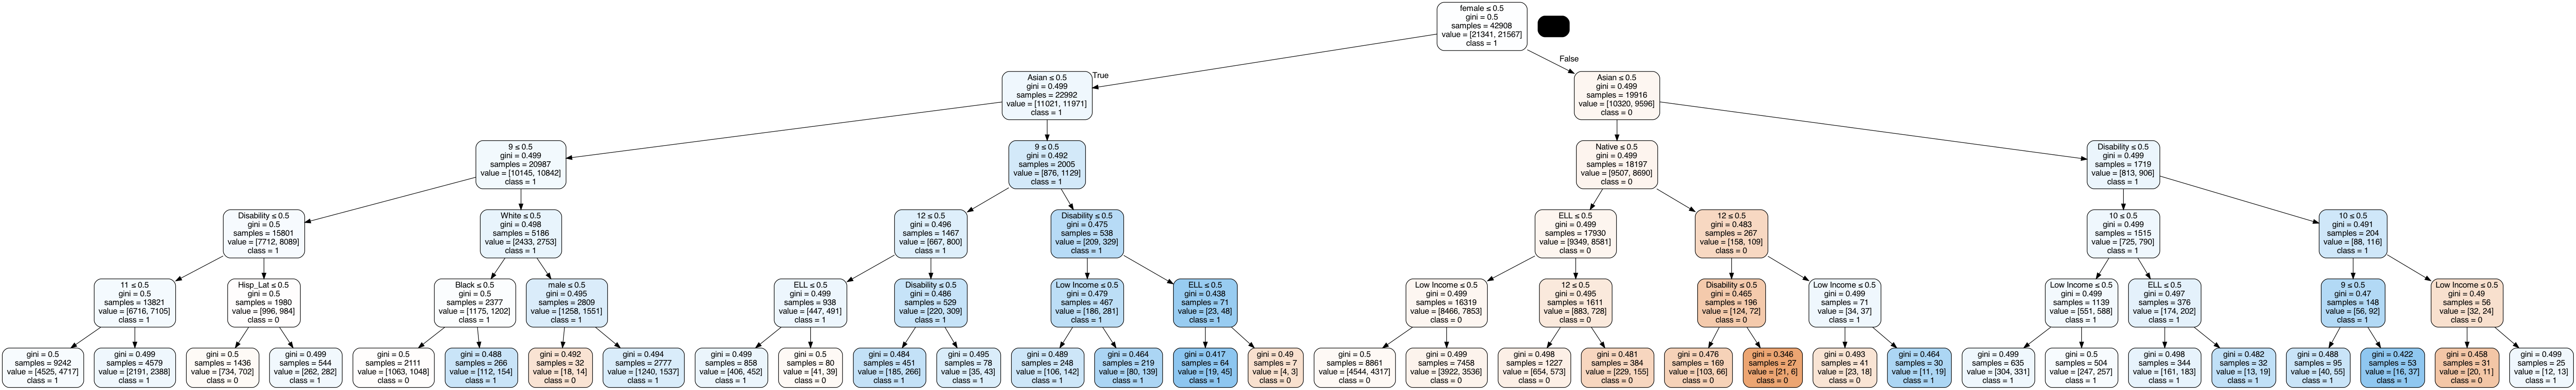

In [549]:
x = df_test_under[student_features]
y = df_test_under.CS_M3

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

clf = DecisionTreeClassifier(max_depth = 5, min_samples_split = 20)
clf = clf.fit(x_train,y_train)

y_pred = clf.predict(x_test)

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = student_features,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('WA_CS_Students_under.png')
Image(graph.create_png())

This already looks more promising than the last tree.

In [550]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5133768352365417


Confusion matrix

 [[4899 4409]
 [4540 4542]]


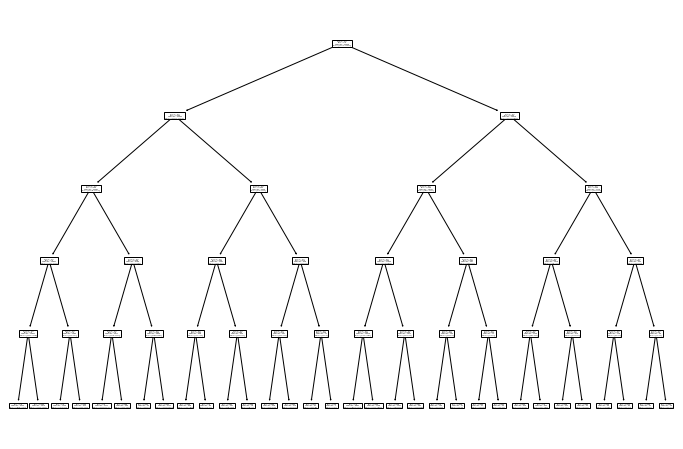

In [551]:
plt.figure(figsize=(12,8))
from sklearn import tree
tree.plot_tree(clf.fit(x_train, y_train))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)

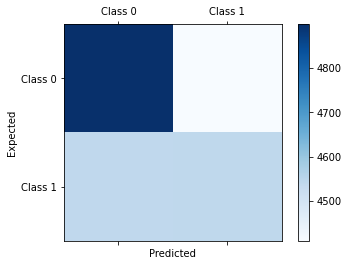

In [552]:
labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

We are hoping for better accuracy than this. One possible way to refine this model is revisiting our undersampling strategy and considering the use of a more advanced module--imbalanced-learn. We can also look back to the data we generated--would generating by school lead to better results?

## Random Forest

## Correlation Heatmap

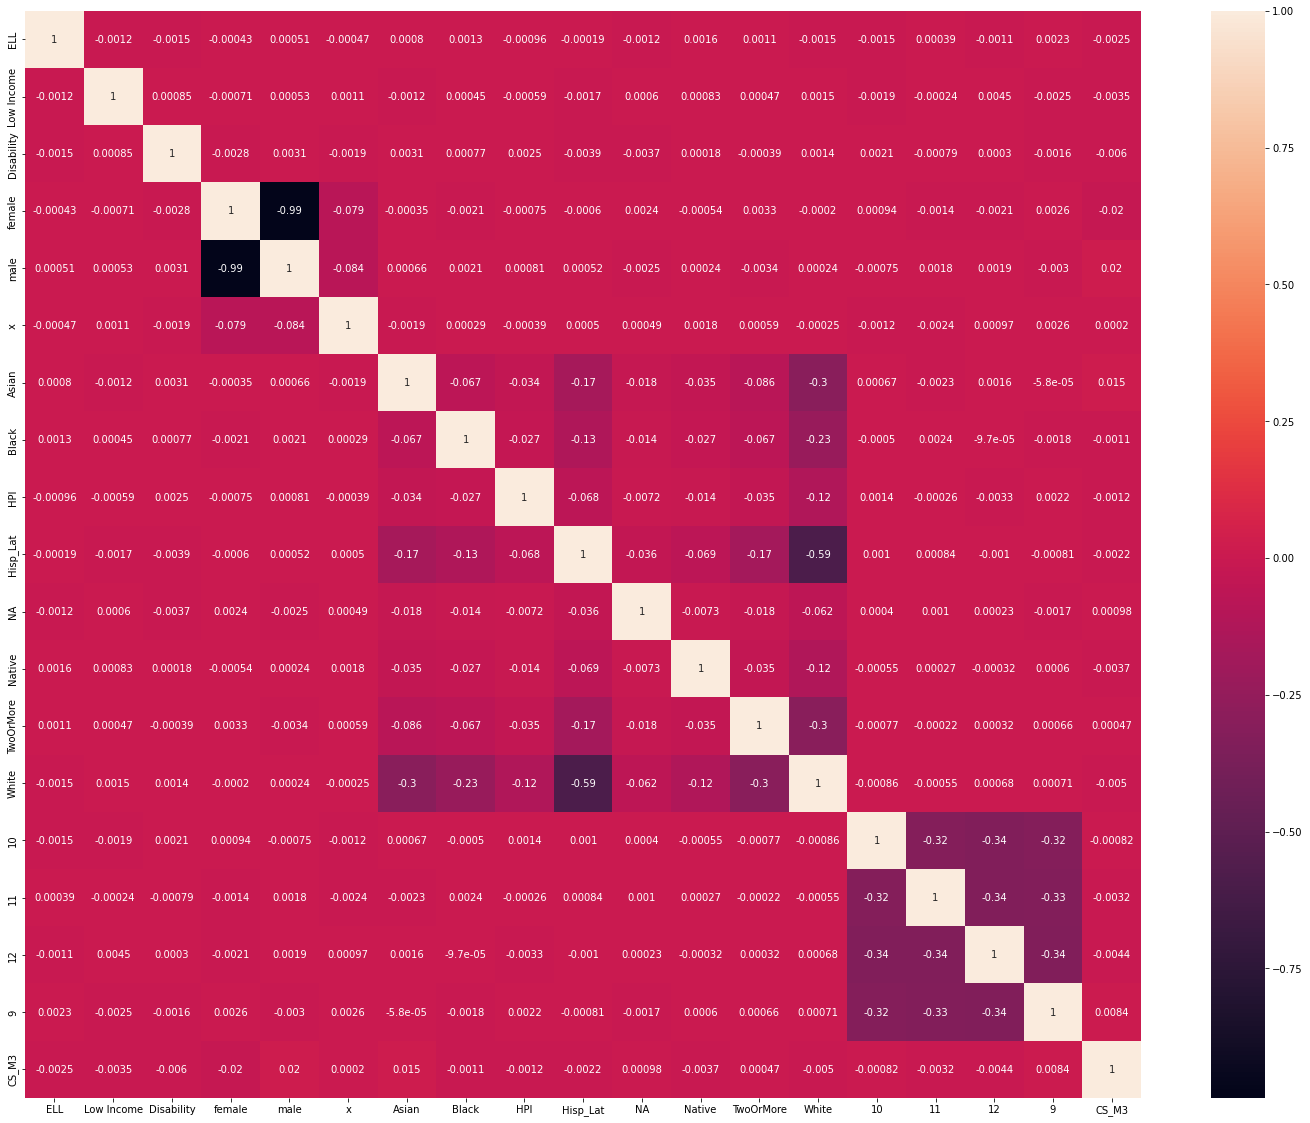

In [553]:
fig = plt.figure(figsize=(25, 20))
sns.heatmap(binary_synth.corr(), annot=True)
plt.savefig("Heatmap.png")

## Logistic Regression

In [554]:
bi_synth_features = binary_synth.copy(deep=False)
bi_synth_features = bi_synth_features.drop('CS_M3', axis=1)

X = bi_synth_features
y = pd.Series(binary_synth.CS_M3)

# Make train and test sets
# from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    shuffle=True, random_state=2)

# Initialize the logistic regression model
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(max_iter=2500)

# Train the model
clf_lr.fit(X_train, y_train)

# Make predictions
y_pred = clf_lr.predict(X_test) # Predictions
y_true = y_test # True values

features = list(X_train.columns)
coefficients = clf_lr.coef_[0]

for feature, coefficient in zip(features, coefficients):
    print(f"{feature}: {coefficient}")


ELL: -0.04617791745907307
Low Income: -0.031630964046021434
Disability: -0.06104741907277609
female: -0.09212948224194635
male: 0.0552277769801837
x: 0.02419365599831707
Asian: 0.1911271634155316
Black: -0.0336746659254444
HPI: -0.042841853166653315
Hisp_Lat: -0.020685449208337117
NA: 0.05756619545510421
Native: -0.1323989074541153
TwoOrMore: 0.0014886569140868846
White: -0.03328918928916664
10: -0.010370400010283443
11: -0.012117110289824186
12: -0.044152662576397265
9: 0.05393212361600432


Eigenvalues:
[1.98681607e+00 1.63404207e+00 1.34768308e+00 1.33084716e+00
 1.32175323e+00 1.18269937e+00 1.08654481e+00 1.05922794e+00
 1.01969693e+00 1.01568315e+00 1.01213307e+00 1.00636069e+00
 1.00189871e+00 9.98518152e-01 9.96140556e-01 1.67927683e-24
 2.81068329e-25 8.64610053e-27]

Variances (Percentage):
[1.10378395e+01 9.07798880e+00 7.48710951e+00 7.39357683e+00
 7.34305517e+00 6.57053563e+00 6.03634498e+00 5.88458498e+00
 5.66496881e+00 5.64267005e+00 5.62294744e+00 5.59087876e+00
 5.56609004e+00 5.54730920e+00 5.53410036e+00 9.32929242e-24
 1.56148681e-24 4.80337717e-26]



Text(0, 0.5, 'Explained variance (%)')

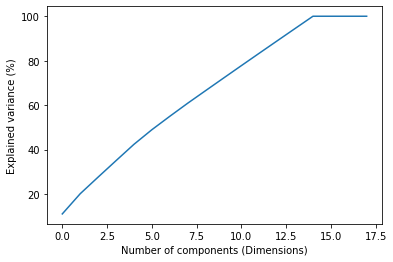

In [555]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=None)
pca.fit(X_scaled)

# Get the eigenvalues
print("Eigenvalues:")
print(pca.explained_variance_)
print()

# Get explained variances
print("Variances (Percentage):")
print(pca.explained_variance_ratio_ * 100)
print()

# Make the scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")

Train accuracy: 0.92
Test accuracy: 0.92

Test confusion_matrix


Text(33.0, 0.5, 'True')

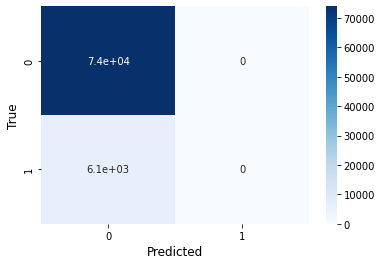

In [556]:
# # Measure accuracy
from sklearn.metrics import accuracy_score
# import numpy as np
print("Train accuracy:", np.round(accuracy_score(y_train, 
                                                 clf_lr.predict(X_train)), 2))
print("Test accuracy:", np.round(accuracy_score(y_true, y_pred), 2))

# # Make the confusion matrix
# from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print("\nTest confusion_matrix")
sns.heatmap(cf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

Unfortunately this model has also fallen to the accuracy paradox. So we can also re-do the analysis with our undersampled dataset.

In [557]:
X = df_test_under[student_features]
y = df_test_under.CS_M3

# Make train and test sets
# from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    shuffle=True, random_state=2)

# Initialize the logistic regression model
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(max_iter=2500)

# Train the model
clf_lr.fit(X_train, y_train)

# Make predictions
y_pred = clf_lr.predict(X_test) # Predictions
y_true = y_test # True values

features = list(X_train.columns)
coefficients = clf_lr.coef_[0]

for feature, coefficient in zip(features, coefficients):
    print(f"{feature}: {coefficient}")

ELL: -0.04210390829892395
Low Income: -0.03064218865161956
Disability: -0.024416208363521808
female: -0.09897751897417083
male: 0.06769223227134866
x: 0.05257572809327383
Asian: 0.17391892852969776
Black: -0.00955546329503573
HPI: 0.04986134381892075
Hisp_Lat: -0.0028688197557364364
NA: -0.045329902739484666
Native: -0.13395009527829982
TwoOrMore: -0.0008006985343101205
White: -0.009984851355305748
10: 0.007031444047136571
11: -0.011679273259620105
12: -0.01788100675439954
9: 0.043819277357312544


Train accuracy: 0.52
Test accuracy: 0.52

Test confusion_matrix


Text(33.0, 0.5, 'True')

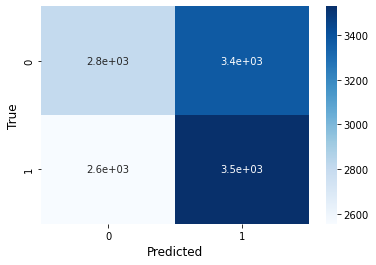

In [558]:
# # Measure accuracy
from sklearn.metrics import accuracy_score
# import numpy as np
print("Train accuracy:", np.round(accuracy_score(y_train, 
                                                 clf_lr.predict(X_train)), 2))
print("Test accuracy:", np.round(accuracy_score(y_true, y_pred), 2))

# # Make the confusion matrix
# from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print("\nTest confusion_matrix")
sns.heatmap(cf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)